In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import dill
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
%matplotlib inline


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### 1. взять любой набор данных для бинарной классификации

In [4]:
df = pd.read_csv("Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [5]:
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [7]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [8]:
numerical_features = ['TotalCharges', 'MonthlyCharges', 'tenure']
categorical_features = ['gender','SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']
target = 'Churn'
feature_cols = numerical_features + categorical_features

Посмотрим распределение численных признаков

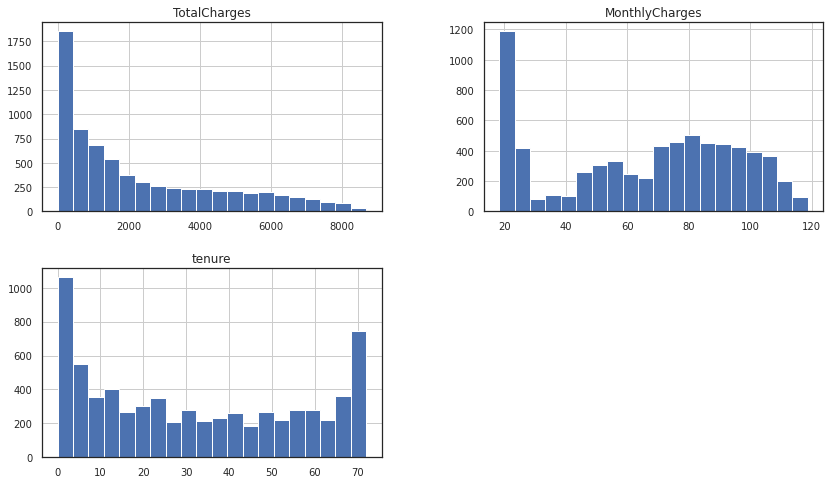

In [12]:
df[numerical_features].hist(figsize=(14,8), bins=20, xlabelsize=10, ylabelsize=10) ;

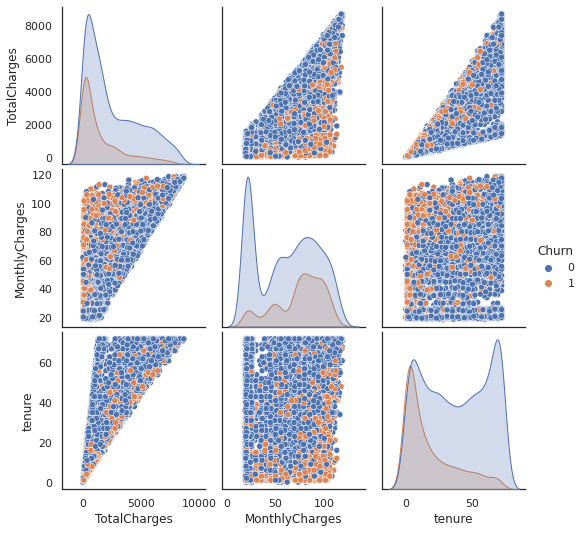

In [13]:
sns.pairplot(data=df[numerical_features + [target]], vars=numerical_features, hue=target)

Посмотрим распределение таргета

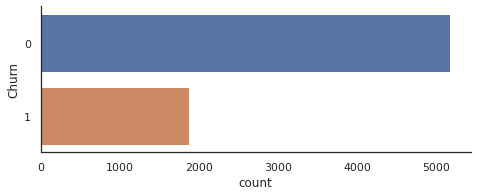

In [14]:
sns.catplot(y=target, kind="count", data=df, height=2.6, aspect=2.5, orient='h')

Посмотрим на категориальные признаки

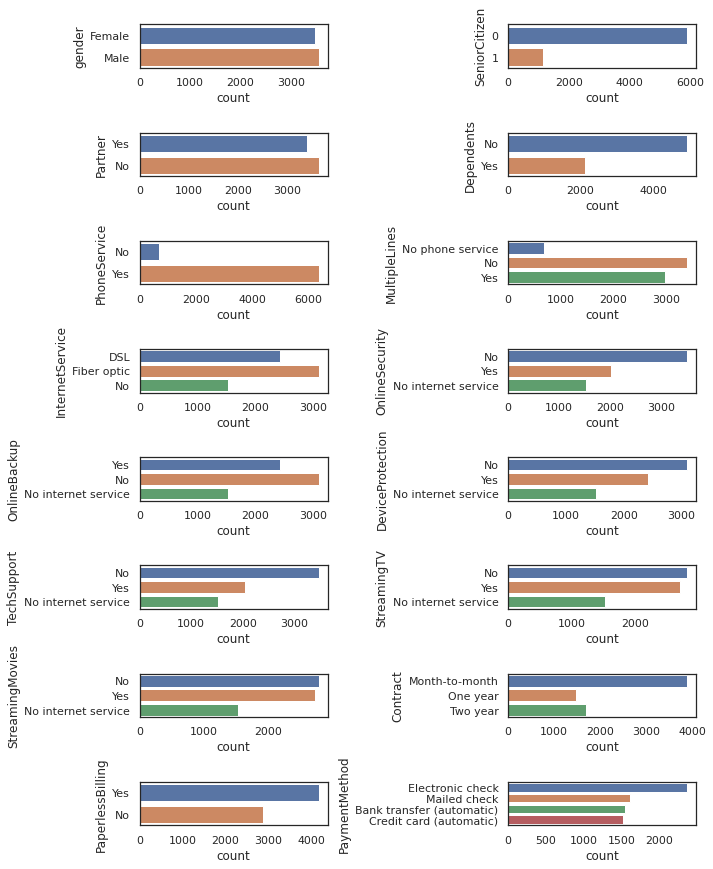

In [15]:
fig, ax = plt.subplots(8, 2, figsize=(10, 12))

for i, ax in enumerate(ax.flat):
    #df[categorical_features[i]].value_counts().plot(kind="barh", ax=ax, figsize=(20,10)).set_title(categorical_features[i])
    sns.countplot(y=df[categorical_features[i]], ax=ax, orient='h')
plt.tight_layout()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df[target], random_state=24)

In [18]:
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

In [11]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", "passthrough", numerical_features),
        ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical_features)
    ]
)

In [ ]:
#запоминаем название столбцов после трансформации
ohe_categories = preprocessor.fit(X_train).named_transformers_["categorical"].categories_
ohe_categories_concat = [f"{col}__{val}" for col, vals in zip(categorical_features, ohe_categories) for val in vals]
categories_encoded = numerical_features + ohe_categories_concat

In [12]:
pipeline = Pipeline([("preprocessor", preprocessor), ("model", xgb.XGBClassifier(max_depth=7, random_state=24))])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=False)

In [20]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [21]:
preds

array([0.7739887 , 0.03250943, 0.6540493 , ..., 0.4600329 , 0.15492709,
       0.0051552 ], dtype=float32)

Best Threshold=0.321929, F-Score=0.607, Precision=0.531, Recall=0.710, roc_auc=0.839
Confusion matrix, without normalization
[[1043  277]
 [ 129  312]]


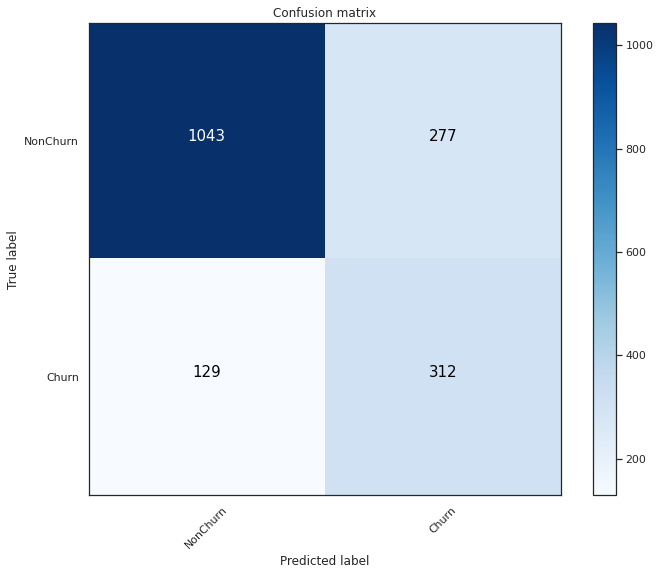

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [25]:
pipeline.steps

[('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('numerical', 'passthrough',
                                   ['TotalCharges', 'MonthlyCharges', 'tenure']),
                                  ('categorical',
                                   OneHotEncoder(categories='auto', drop=None,
                                                 dtype=<class 'numpy.float64'>,
                                                 handle_unknown='ignore',
                                                 sparse=False),
                                   ['gender', 'SeniorCitizen', 'Partner',
                                    'Dependents', 'PhoneService', 'MultipleLines',
                                    'InternetService', 'OnlineSecurity',
                                    'OnlineBackup', 'DeviceProtection',
                                    'TechSupport', 'StreamingTV',
   

Сохраним модель (пайплайн)

In [30]:
with open("xgb_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)